# CaImAn NoRMCorre for ISXD file
In this notebook I load an ISXD movie and test the built-in NoRMCorre algorithm on it. The final goal is to produce a motion-corrected movie which I can use for my other processing (in particular, there were concerns that temporally-local means, which were supposed to increase SNR, would cause blurring due to motion. By performing the motion correction, I hope to eliminate this blurring effect.

The more immediate objective of this notebook is to test the various parameters that we could use for the motion correction, to experimentally optimize the motion correction before actually saving the thing and then using it for my later processing.

In [1]:
# imports, copied from caiman_data/demos/notebooks/demo_motion_correction.ipynb
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div

import cv2
import matplotlib.pyplot as plt
import numpy as np
import logging

try:
    cv2.setNumThreads(0)
except:
    pass

try:
    if __IPYTHON__:
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.DEBUG)

import caiman as cm
from caiman.motion_correction import MotionCorrect, tile_and_correct, motion_correction_piecewise
from caiman.utils.utils import download_demo

/tmp/ipykernel_1450110/1782807027.py:20: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('load_ext autoreload')
/tmp/ipykernel_1450110/1782807027.py:21: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('autoreload 2')
        1601 [__init__.py:            <module>():47] [1450110] Creating converter from 7 to 5
        1602 [__init__.py:            <module>():47] [1450110] Creating converter from 5 to 7
        1602 [__init__.py:            <module>():47] [1450110] Creating converter from 7 to 5
        1603 [__init__.py:            <module>():47] [1450110] Creating converter from 5 to 7
2023-01-04 15:15:32.080528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CP

In [2]:
# load our isxd file as a complete ndarray
import isxd_reader

full_stack = isxd_reader.img_stack("2022-10-14-07-48-47_video.isxd")

        5711 [pyplot.py:      switch_backend():316] [1450110] Loaded backend module://matplotlib_inline.backend_inline version unknown.
        5713 [pyplot.py:      switch_backend():316] [1450110] Loaded backend module://matplotlib_inline.backend_inline version unknown.
        5715 [font_manager.py:    _findfont_cached():1467] [1450110] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
        5715 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/home/dshteinbok/miniconda3/envs/caiman/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
        5716 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/home/dshteinbok/miniconda3/envs/caiman/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.tt

        5724 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/home/dshteinbok/miniconda3/envs/caiman/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5724 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/home/dshteinbok/miniconda3/envs/caiman/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
        5724 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/home/dshteinbok/miniconda3/envs/caiman/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'))

        5730 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansLisu-SemiBold.ttf', name='Noto Sans Lisu', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
        5730 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansDevanagariUI-Bold.ttf', name='Noto Sans Devanagari UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5731 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Garuda.ttf', name='Garuda', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5731 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ttf-khmeros-core/KhmerOSsys.ttf', name='Khmer OS System', s

        5738 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerifThai-Bold.ttf', name='Noto Serif Thai', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5738 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
        5738 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansTaiLe-Regular.ttf', name='Noto Sans Tai Le', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5739 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc', name='Noto San

        5745 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansTifinagh-Regular.ttf', name='Noto Sans Tifinagh', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5746 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansSinhala-Bold.ttf', name='Noto Sans Sinhala', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5746 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerifMalayalam-Bold.ttf', name='Noto Serif Malayalam', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5746 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansMyanmar-Regular.tt

        5753 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansOsmanya-Regular.ttf', name='Noto Sans Osmanya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5753 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansAdlam-Regular.ttf', name='Noto Sans Adlam', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5753 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansKhmer-Regular.ttf', name='Noto Sans Khmer', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5754 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-beng-extra/JamrulNormal.ttf', name='J

        5760 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusRoman-BoldItalic.otf', name='Nimbus Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
        5761 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc', name='Noto Serif CJK JP', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5761 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansTibetan-Regular.ttf', name='Noto Sans Tibetan', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5761 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/malayalam/Manjari-Thin.otf', name='Manj

        5769 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/abyssinica/AbyssinicaSIL-Regular.ttf', name='Abyssinica SIL', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5769 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/URWBookman-Light.otf', name='URW Bookman', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
        5769 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerifGurmukhi-Bold.ttf', name='Noto Serif Gurmukhi', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5769 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-deva-extra/samanata.ttf', name='

        5776 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-BI.ttf', name='Ubuntu Mono', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
        5776 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansAvestan-Regular.ttf', name='Noto Sans Avestan', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5777 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoNaskhArabic-Regular.ttf', name='Noto Naskh Arabic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5777 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstQurn.ttf', name='KacstQurn', style='n

        5784 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansMyanmarUI-Regular.ttf', name='Noto Sans Myanmar UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5784 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansOriyaUI-Bold.ttf', name='Noto Sans Oriya UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5784 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Garuda-Bold.ttf', name='Garuda', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5785 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSans-Regular.ttf', name='Noto Sans', style='

        5791 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansTaiTham-Regular.ttf', name='Noto Sans Tai Tham', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5792 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-C.ttf', name='Ubuntu Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
        5792 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-devanagari/Lohit-Devanagari.ttf', name='Lohit Devanagari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5792 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerifBalinese-Regular.ttf', name

        5799 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansBengali-Bold.ttf', name='Noto Sans Bengali', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5799 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerifDevanagari-Bold.ttf', name='Noto Serif Devanagari', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5800 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansGujarati-Regular.ttf', name='Noto Sans Gujarati', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5800 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeMonoBoldOblique.

        5807 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/AnjaliOldLipi-Regular.ttf', name='AnjaliOldLipi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5807 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lyx/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5807 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansModi-Regular.ttf', name='Noto Sans Modi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5807 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-kannada/Lohit-Kannada.ttf', name='Lohit Kannada', style='normal',

        5815 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgMono-Bold.ttf', name='Tlwg Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5815 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstArt.ttf', name='KacstArt', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
        5815 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeMono.ttf', name='FreeMono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5815 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSerif-Italic.ttf', name='Liberation Serif', style='italic', variant='nor

        5822 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansMayanNumerals-Regular.ttf', name='Noto Sans Mayan Numerals', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5822 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansWarangCiti-Regular.ttf', name='Noto Sans Warang Citi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5823 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/quicksand/Quicksand-Light.ttf', name='Quicksand Light', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
        5823 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusSa

        5830 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansTelugu-Bold.ttf', name='Noto Sans Telugu', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5830 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/hack/Hack-Bold.ttf', name='Hack', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5830 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ttf-bitstream-vera/VeraMoBI.ttf', name='Bitstream Vera Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
        5831 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/glyphicons/glyphicons-halflings-regular.ttf', name='GLYPH

        5837 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-B.ttf', name='Ubuntu Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5838 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansBengaliUI-Bold.ttf', name='Noto Sans Bengali UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5838 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-bengali/Lohit-Bengali.ttf', name='Lohit Bengali', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5838 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-beng-extra/LikhanNormal.ttf', name='Likhan', 

        5845 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/C059-Bold.otf', name='C059', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5846 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/Uroob-Regular.ttf', name='Uroob', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5846 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansSymbols2-Regular.ttf', name='Noto Sans Symbols2', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5846 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansTamilUI-Bold.ttf', name='Noto Sans Tamil UI', style='norm

        5853 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Kinnari.ttf', name='Kinnari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5853 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansGurmukhi-Regular.ttf', name='Noto Sans Gurmukhi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5854 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansOldHungarian-Regular.ttf', name='Noto Sans Old Hungarian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5854 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/P052-Roman.otf', name='P052', style='

        5861 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerifBengali-Bold.ttf', name='Noto Serif Bengali', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5861 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansMasaramGondi-Regular.ttf', name='Noto Sans Masaram Gondi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5861 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstPen.ttf', name='KacstPen', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
        5862 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansNewa-Regular.ttf', name='Noto San

        5869 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerifDevanagari-Regular.ttf', name='Noto Serif Devanagari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
        5869 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Purisa-BoldOblique.ttf', name='Purisa', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
        5869 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSerifTelugu-Bold.ttf', name='Noto Serif Telugu', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
        5870 [font_manager.py:    _findfont_cached():1479] [1450110] findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansDeseret-Regular.ttf', name='No

        5876 [font_manager.py:    _findfont_cached():1508] [1450110] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/dshteinbok/miniconda3/envs/caiman/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


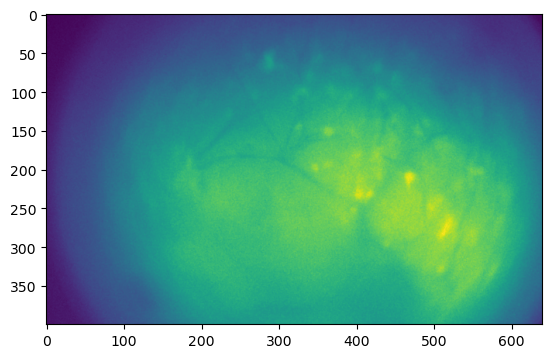

In [3]:
plt.imshow(full_stack[0])

The first frame from the movie loaded above works, let's play the movie itself

In [4]:
m_orig = cm.movie(full_stack)
m_orig.play(fr=100)

qt.qpa.xcb: X server does not support XInput 2
failed to get the current screen resources
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-dshteinbok'
qt.qpa.gl: QXcbConnection: Failed to initialize GLX
qt.qpa.xcb: QXcbConnection: XCB error: 1 (BadRequest), sequence: 165, resource id: 90, major code: 130 (Unknown), minor code: 47
qt.qpa.xcb: QXcbConnection: XCB error: 170 (Unknown), sequence: 180, resource id: 90, major code: 146 (Unknown), minor code: 20


From the movie played in the cell above, you can see that the main motion is in deformation of the brain, not overall motion. This means that what we have is definitely non-rigid, and that we should probably use smaller frames to represent this.

Qualitatively, it seems that the motion is very localized around blood vessels and correlated with their motion. The conclusion is the same.

## Rigid Motion Correction
Here, we have some rigid motion correction just to check how good an effect this alone has. Also, this is the order in which it's demonstrated in the demo notebook. After this, I will try the non-rigid motion.

In [5]:
max_shifts = (6, 6)  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
strides =  (48, 48)  # create a new patch every x pixels for pw-rigid correction
overlaps = (24, 24)  # overlap between pathes (size of patch strides+overlaps)
max_deviation_rigid = 3   # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = False  # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True  # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'  # replicate values along the boundary (if True, fill in with NaN)

# My addition, high pass spatial filtering because this is 1p data.
gSig_filt = (3, 3)       # size of high pass spatial filtering, used in 1p data

In [6]:
#%% start the cluster (if a cluster already exists terminate it)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

       37119 [motion_correction.py:tile_and_correct_wrapper():3103] [1450338] 0
       37120 [motion_correction.py:tile_and_correct_wrapper():3103] [1450337] 0
       37124 [motion_correction.py:tile_and_correct_wrapper():3103] [1450339] 0
       37125 [motion_correction.py:tile_and_correct_wrapper():3103] [1450340] 0
       37130 [motion_correction.py:tile_and_correct_wrapper():3103] [1450341] 0
       37129 [motion_correction.py:tile_and_correct_wrapper():3103] [1450342] 0
       37135 [motion_correction.py:tile_and_correct_wrapper():3103] [1450343] 0
       37139 [motion_correction.py:tile_and_correct_wrapper():3103] [1450345] 0
       37139 [motion_correction.py:tile_and_correct_wrapper():3103] [1450344] 0
       37144 [motion_correction.py:tile_and_correct_wrapper():3103] [1450348] 0
       37144 [motion_correction.py:tile_and_correct_wrapper():3103] [1450347] 0
       37144 [motion_correction.py:tile_and_correct_wrapper():3103] [1450349] 0
       37144 [motion_correction.py:tile_

To perform the motion correction and other processing, CaImAn requires a saved file and a path to it. CaImAn cannot load ISXD files. Consequently, we need to somehow save the movie in a loadable format (e.g. `tif`). Fortunately, CaImAn provides the `movie.save()` function to do so from the movie we've initialized and played above.

In [7]:
m_orig.save("2022-10-14-07-48-47_video.tif")

       34703 [timeseries.py:                save():175] [1450110] Parsing extension .tif
       34716 [timeseries.py:                 foo():182] [1450110] 0 frames saved


In [8]:
fnames = ["2022-10-14-07-48-47_video.tif"]

In [9]:
#cm.load_movie_chain(fnames).play()
# above works

In [10]:
# create a motion correction object
mc = MotionCorrect(fnames, dview=dview, max_shifts=max_shifts,
                  strides=strides, overlaps=overlaps,
                  max_deviation_rigid=max_deviation_rigid, 
                  shifts_opencv=shifts_opencv, nonneg_movie=True,
                  border_nan=border_nan,
                  gSig_filt=gSig_filt)

In [11]:
%%capture
# correct for rigid motion correction and save the file (in memory mapped form)
mc.motion_correct(save_movie=True)

       35682 [motion_correction.py:motion_correct_rigid():295] [1450110] Entering Rigid Motion Correction
       35683 [motion_correction.py:motion_correct_rigid():296] [1450110] 6.1887474
       35909 [movies.py:      extract_shifts():342] [1450110] min_val in extract_shifts: -1.2869652593135834
       35909 [movies.py:      extract_shifts():343] [1450110] Movie average is negative. Removing 1st percentile.
       35916 [movies.py:      extract_shifts():361] [1450110] Movie average is negative. Removing 1st percentile.
       36077 [movies.py:        apply_shifts():439] [1450110] cubic interpolation
       36338 [movies.py:      extract_shifts():342] [1450110] min_val in extract_shifts: -1.2869652593135834
       36339 [movies.py:      extract_shifts():343] [1450110] Movie average is negative. Removing 1st percentile.
       36346 [movies.py:      extract_shifts():361] [1450110] Movie average is negative. Removing 1st percentile.
       36506 [movies.py:        apply_shifts():439] [14

In [12]:
# load motion corrected movie
m_rig = cm.load(mc.mmap_file)
bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(np.int)

  0%|                                                                                                                                                                  | 0/1 [00:00<?, ?it/s]       37708 [movies.py:                load():1709] [1450110] loading mmap file in memory
       38381 [movies.py:                load():1712] [1450110] mmap
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]
/tmp/ipykernel_1450110/744089657.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidan

In [13]:
m_rig.play(fr=30, bord_px = 0*bord_px_rig) # press q to exit

The video that played above was rigid motion correction, and it is clear that there was some rigid motion in the original move which was removed here. However, we definintely still see some non-rigid motion here near the end of the recording, when it looks like something pumps through the blood vessels and we see the local "squeezing" on the right side of the field of view.

### NOTE on the spatial high-pass filtering:
Even without a high-pass filter, I didn't see any issues with the high frequency landmarks shifting. I then proceeded to use the same filter that the authors use, namely a kernel of `(3,3)`. Again, everything continued to look good. It could just be the case that the low frequency component is either not dominant or moves with the rest of the video, and so this just works for this particular video. The effect of different kernels warrants investigation.

## Non-rigid motion correction:

In [14]:
%%capture
#%% motion correct piecewise rigid
mc.pw_rigid = True  # turn the flag to True for pw-rigid motion correction
mc.template = mc.mmap_file  # use the template obtained before to save in computation (optional)

mc.motion_correct(save_movie=True, template=mc.total_template_rig)
m_els = cm.load(mc.fname_tot_els)
m_els.play(fr=30, bord_px = bord_px_rig)

       58742 [motion_correction.py:motion_correct_batch_pwrigid():3003] [1450110] Adding to movie 6.1887474
       58742 [motion_correction.py:motion_correct_batch_pwrigid():3006] [1450110] 0
       58743 [motion_correction.py:motion_correct_batch_pwrigid():3016] [1450110] saving mmap of 2022-10-14-07-48-47_video.tif
       58744 [motion_correction.py:motion_correction_piecewise():3159] [1450110] Number of Splits: 14
       58754 [motion_correction.py:motion_correction_piecewise():3197] [1450110] Saving file as 2022-10-14-07-48-47_video_els__d1_400_d2_640_d3_1_order_F_frames_80_.mmap
       58754 [motion_correction.py:motion_correction_piecewise():3203] [1450110] Processing: frames: [0 1 2 3 4 5]
       58755 [motion_correction.py:motion_correction_piecewise():3203] [1450110] Processing: frames: [ 6  7  8  9 10 11]
       58755 [motion_correction.py:motion_correction_piecewise():3203] [1450110] Processing: frames: [12 13 14 15 16 17]
       58756 [motion_correction.py:motion_correction

In [23]:
# downsample_ratio = 0.5
downsample_ratio = 1

In [26]:
cm.concatenate([m_orig.resize(1, 1, downsample_ratio) - mc.min_mov*mc.nonneg_movie,
                m_rig.resize(1, 1, downsample_ratio), m_els.resize(
            1, 1, downsample_ratio)], axis=2).play(fr=60, bord_px=bord_px_rig)

Now, I just have to save the movie again. Perhaps a `tif` will work.

In [28]:
m_els.save("2022-10-14-07-48-47_video_normcorre.tif")

     1880523 [timeseries.py:                save():175] [1450110] Parsing extension .tif
     1880537 [timeseries.py:                 foo():182] [1450110] 0 frames saved


In [30]:
cm.load_movie_chain(["2022-10-14-07-48-47_video_normcorre.tif"]).play()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


In [31]:
# now, we want to show that this can be loaded via imageio as an ndarray
import imageio
tif = imageio.imread("2022-10-14-07-48-47_video_normcorre.tif")

/tmp/ipykernel_1450110/2669548601.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  tif = imageio.imread("2022-10-14-07-48-47_video_normcorre.tif")


In [32]:
tif.shape

(80, 400, 640)

**BOOM!** To read the new motion-corrected `tif`, just use regular old `imageio.imread` which automatically gives you the multidimensional ndarray that you want.